In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import PIL
import os
import os.path
from PIL import Image

f = r'/content/drive/MyDrive/finalproject1/normal2'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((256,256))
    img.save(f_img)

In [ ]:
import PIL
import os
import os.path
from PIL import Image

f = r'/content/drive/MyDrive/finalproject1/diseased2'
for file in os.listdir(f):
    f_img = f+"/"+file
    img = Image.open(f_img)
    img = img.resize((256,256))
    img.save(f_img)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model, Sequential
import numpy as np
import pandas as pd
import shutil
import time
import cv2 as cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import os
import seaborn as sns
sns.set_style('darkgrid')
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
from IPython.core.display import display, HTML

In [ ]:
lung_dir=r'/content/drive/MyDrive/finalproject1'
for i,d in enumerate([lung_dir]):
    filepaths=[]
    labels=[]
    classlist=os.listdir(d)
    for klass in classlist:
        classpath=os.path.join(d,klass)
        if os.path.isdir(classpath):
            flist=os.listdir(classpath)
            for f in flist:
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    lung_df=pd.concat([Fseries, Lseries], axis=1)
df=pd.concat([lung_df], axis =0).reset_index(drop=True)# make a combined dataframe

print(df['labels'].value_counts())

labels
diseased2    2132
normal2      2119
Name: count, dtype: int64


In [ ]:
train_split=.8
test_split=.1
dummy_split=test_split/(1-train_split)
train_df, dummy_df=train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=dummy_split, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), ' _test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  3400  _test_df length:  425   valid_df length:  426


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):
    return img/127.5-1  # scale pixel between -1 and +1
gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='binary',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)

test batch size:  25   test steps:  17
Found 3400 validated image filenames belonging to 2 classes.
Found 425 validated image filenames belonging to 2 classes.
Found 426 validated image filenames belonging to 2 classes.


In [ ]:
def print_in_color(txt_msg,fore_tupple,back_tupple,):
    #prints the text_msg in the foreground color specified by fore_tupple with the background specified by back_tupple
    #text_msg is the text, fore_tupple is foregroud color tupple (r,g,b), back_tupple is background tupple (r,g,b)
    rf,gf,bf=fore_tupple
    rb,gb,bb=back_tupple
    msg='{0}' + txt_msg
    mat='\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m'
    print(msg .format(mat), flush=True)
    print('\33[0m', flush=True) # returns default print color to back to black
    return

In [ ]:
class LRA(keras.callbacks.Callback):
    reset=False
    count=0
    stop_count=0
    tepochs=0
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze, initial_epoch):
        super(LRA, self).__init__()
        self.model=model
        self.patience=patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience=stop_patience
        self.threshold=threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor=factor # factor by which to reduce the learning rate
        self.dwell=dwell
        self.lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initiallearning rate and save it in self.lr
        self.highest_tracc=0.0 # set highest training accuracy to 0
        self.lowest_vloss=np.inf # set lowest validation loss to infinity
        #self.count=0 # initialize counter that counts epochs with no improvement
        #self.stop_count=0 # initialize counter that counts how manytimes lr has been adjustd with no improvement
        self.initial_epoch=initial_epoch
        #self.epochs=epochs
        best_weights=self.model.get_weights() # set a class vaiable so weights can be loaded after training is completed
        msg=' '
        if freeze==True:
            msgs=f' Starting training using  base model { model_name} with weights frozen to imagenet weights initializing LRA callback'
        else:
            msgs=f' Starting training using base model { model_name} training all layers '
        print_in_color (msgs, (244, 252, 3), (55,65,80))

    def on_epoch_begin(self,epoch, logs=None):
        self.now= time.time()

    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        later=time.time()
        duration=later-self.now
        if epoch== self.initial_epoch or LRA.reset==True:
            LRA.reset=False
            msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^11s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy','V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
            print_in_color(msg, (244,252,3), (55,65,80))

        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')
        #print ( '\n',v_loss, self.lowest_vloss, acc, self.highest_tracc)
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc=acc # set new highest training accuracy
                LRA.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.lr=lr
            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1:
                    color=(245, 170, 66)
                    self.lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss
                else:
                    self.count=self.count +1 # increment patience counter
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss
                LRA.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved
                self.stop_count=0
                color=(0,255,0)
                self.lr=lr
            else: # validation loss did not improve
                if self.count>=self.patience-1:
                    color=(245, 170, 66)
                    self.lr=self.lr * self.factor # adjust the learning rate
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr) # set the learning rate in the optimizer
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights) # return to better point in N space
                else:
                    self.count =self.count +1 # increment the patience counter
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55,65,80))
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print_in_color(msg, (0,255,0), (55,65,80))
            self.model.stop_training = True # stop training

In [ ]:
%load_ext tensorboard
import tensorflow as tf
import datetime, os
%reload_ext tensorboard

In [ ]:
def tr_plot(tr_data, start_epoch,p,r):
    #Plot the training and validation data
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    tpre = tr_data.history[p]
    trec = tr_data.history[r]
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    vpre = tr_data.history['val_'+p]
    vrec = tr_data.history['val_'+r]
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss) # this is the epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))

    # Loss and accuracy plots
    axes[0][0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0][0].plot(Epochs, vloss,'g',label='Validation loss' )
    axes[0][0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0][0].set_title('Training and Validation Loss')
    axes[0][0].set_xlabel('Epochs')
    axes[0][0].set_ylabel('Loss')
    axes[0][0].legend()

    axes[0][1].plot(Epochs, tacc,'r',label='Training Accuracy')
    axes[0][1].plot(Epochs, vacc,'g',label='Validation Accuracy')
    axes[0][1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[0][1].set_title('Training and Validation Accuracy')
    axes[0][1].set_xlabel('Epochs')
    axes[0][1].set_ylabel('Accuracy')
    axes[0][1].legend()

    # Precision and recall plots
    axes[1][0].plot(Epochs, tpre,'r',label='Training Precision')
    axes[1][0].plot(Epochs, vpre,'g',label='Validation Precision')
    axes[1][0].set_title('Training and Validation Precision')
    axes[1][0].set_xlabel('Epochs')
    axes[1][0].set_ylabel('Precision')
    axes[1][0].legend()

    axes[1][1].plot(Epochs, trec,'r',label='Training Recall')
    axes[1][1].plot(Epochs, vrec,'g',label='Validation Recall')
    axes[1][1].set_title('Training and Validation Recall')
    axes[1][1].set_xlabel('Epochs')
    axes[1][1].set_ylabel('Recall')
    axes[1][1].legend()

    plt.tight_layout()

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    file_names= test_gen.filenames
    error_list=[]
    true_class=[]
    pred_class=[]
    prob_list=[]
    new_dict={}
    error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names
    dict_as_text=str(new_dict)
    dict_name= subject + '-' +str(len(classes)) +'.txt'
    dict_path=os.path.join(save_dir,dict_name)
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)
    errors=0
    for i, p in enumerate(preds):
        pred_index=np.argmax(p)
        true_index=labels[i]  # labels are integer values
        if pred_index != true_index: # a misclassification has occurred
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)
            errors=errors + 1
        y_pred.append(pred_index)
    if print_code !=0:
        if errors>0:
            if print_code>errors:
                r=errors
            else:
                r=print_code
            msg='{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0,255,0),(55,65,80))
            for i in range(r):
                split1=os.path.split(error_list[i])
                split2=os.path.split(split1[0])
                fname=split2[1] + '/' + split1[1]
                msg='{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i],true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255,255,255), (55,65,60))
                #print(error_list[i]  , pred_class[i], true_class[i], prob_list[i])
        else:
            msg='With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0,255,0),(55,65,80))
    if errors>0:
        plot_bar=[]
        plot_class=[]
        for  key, value in new_dict.items():
            count=error_indices.count(key)
            if count!=0:
                plot_bar.append(count) # list containg how many times a class c had an error
                plot_class.append(value)   # stores the class
        fig=plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        for i in range(0, len(plot_class)):
            c=plot_class[i]
            x=plot_bar[i]
            plt.barh(c, x, )
            plt.title( ' Errors by Class on Test Set')
    y_true= np.array(labels)
    y_pred=np.array(y_pred)
    if len(classes)<= 30:
        # create a confusion matrix
        cm = confusion_matrix(y_true, y_pred )
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    # Assuming you have your test data and predicted scores in y_test and y_pred respectively
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)

    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--') # Plot diagonal line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\n----------------------\n", clr)

# **VGG19**

In [ ]:
from keras.applications.vgg19 import VGG19
from keras.metrics import Recall,Precision
model_name='VGG19'
base_model = VGG19(input_shape=(224, 224, 3), weights='imagenet', pooling="avg", include_top=False)
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(1 , activation='sigmoid')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(lr=.001), loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])

In [ ]:
epochs = 50
patience= 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience =3 # number of epochs to wait before stopping training if monitored value does not improve
threshold=.9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor=.5 # factor to reduce lr by
dwell=True # experimental, if True and monitored metric does not improve on current epoch set  modelweights back to weights of previous epoch
freeze=False # if true free weights of  the base model
logdir = os.path.join("logs/Adamax", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
callbacks=[LRA(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name, freeze=freeze, initial_epoch=0 ),tensorboard_callback]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history=model.fit(x=train_gen,  epochs=epochs, callbacks=callbacks, verbose=0,  validation_data=valid_gen, validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model VGG19 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /50     3.436   53.000   2.56797  46.479   0.00100  0.00100  accuracy   102.06 

 2 /50     1.564   55.588   1.55851  46.479   0.00100  0.00100  accuracy   52.99  

 3 /50     1.130   55.912   1.17391  49.531   0.00100  0.00100  accuracy   52.40  

 4 /50     0.943   56.294   1.10397  53.052   0.00100  0.00100  accuracy   52.94  

 5 /50     0.834   60.353   0.99807  56.338   0.00100  0.00100  accuracy   52.79  

 6 /50     0.750   65.853   1.78442  46.948   0.00100  0.00100  accuracy   52.79  

 7 /50     0.700   68.118   0.71284  69.014   0.00100  0.00100  accuracy   52.89  

 8 /50     0.672   69.500   0.73259  62.441   0.00100  0.00100  accuracy   52.68  

 9 /50     0.643   71.882   0.85470  58.920   0.00100  0.00100  accuracy   52.58  

10 /50     0.628   70.853   0.84033  54.930   0.00100  0.00050  accuracy   52.62  

11 /50     0

In [ ]:
keys = history.history.keys()
print(keys)

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


17/17 [==============================] - 8s 135ms/step - loss: 0.4710 - accuracy: 0.8235 - precision: 0.9212 - recall: 0.7103
accuracy on the test set is 82.35 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


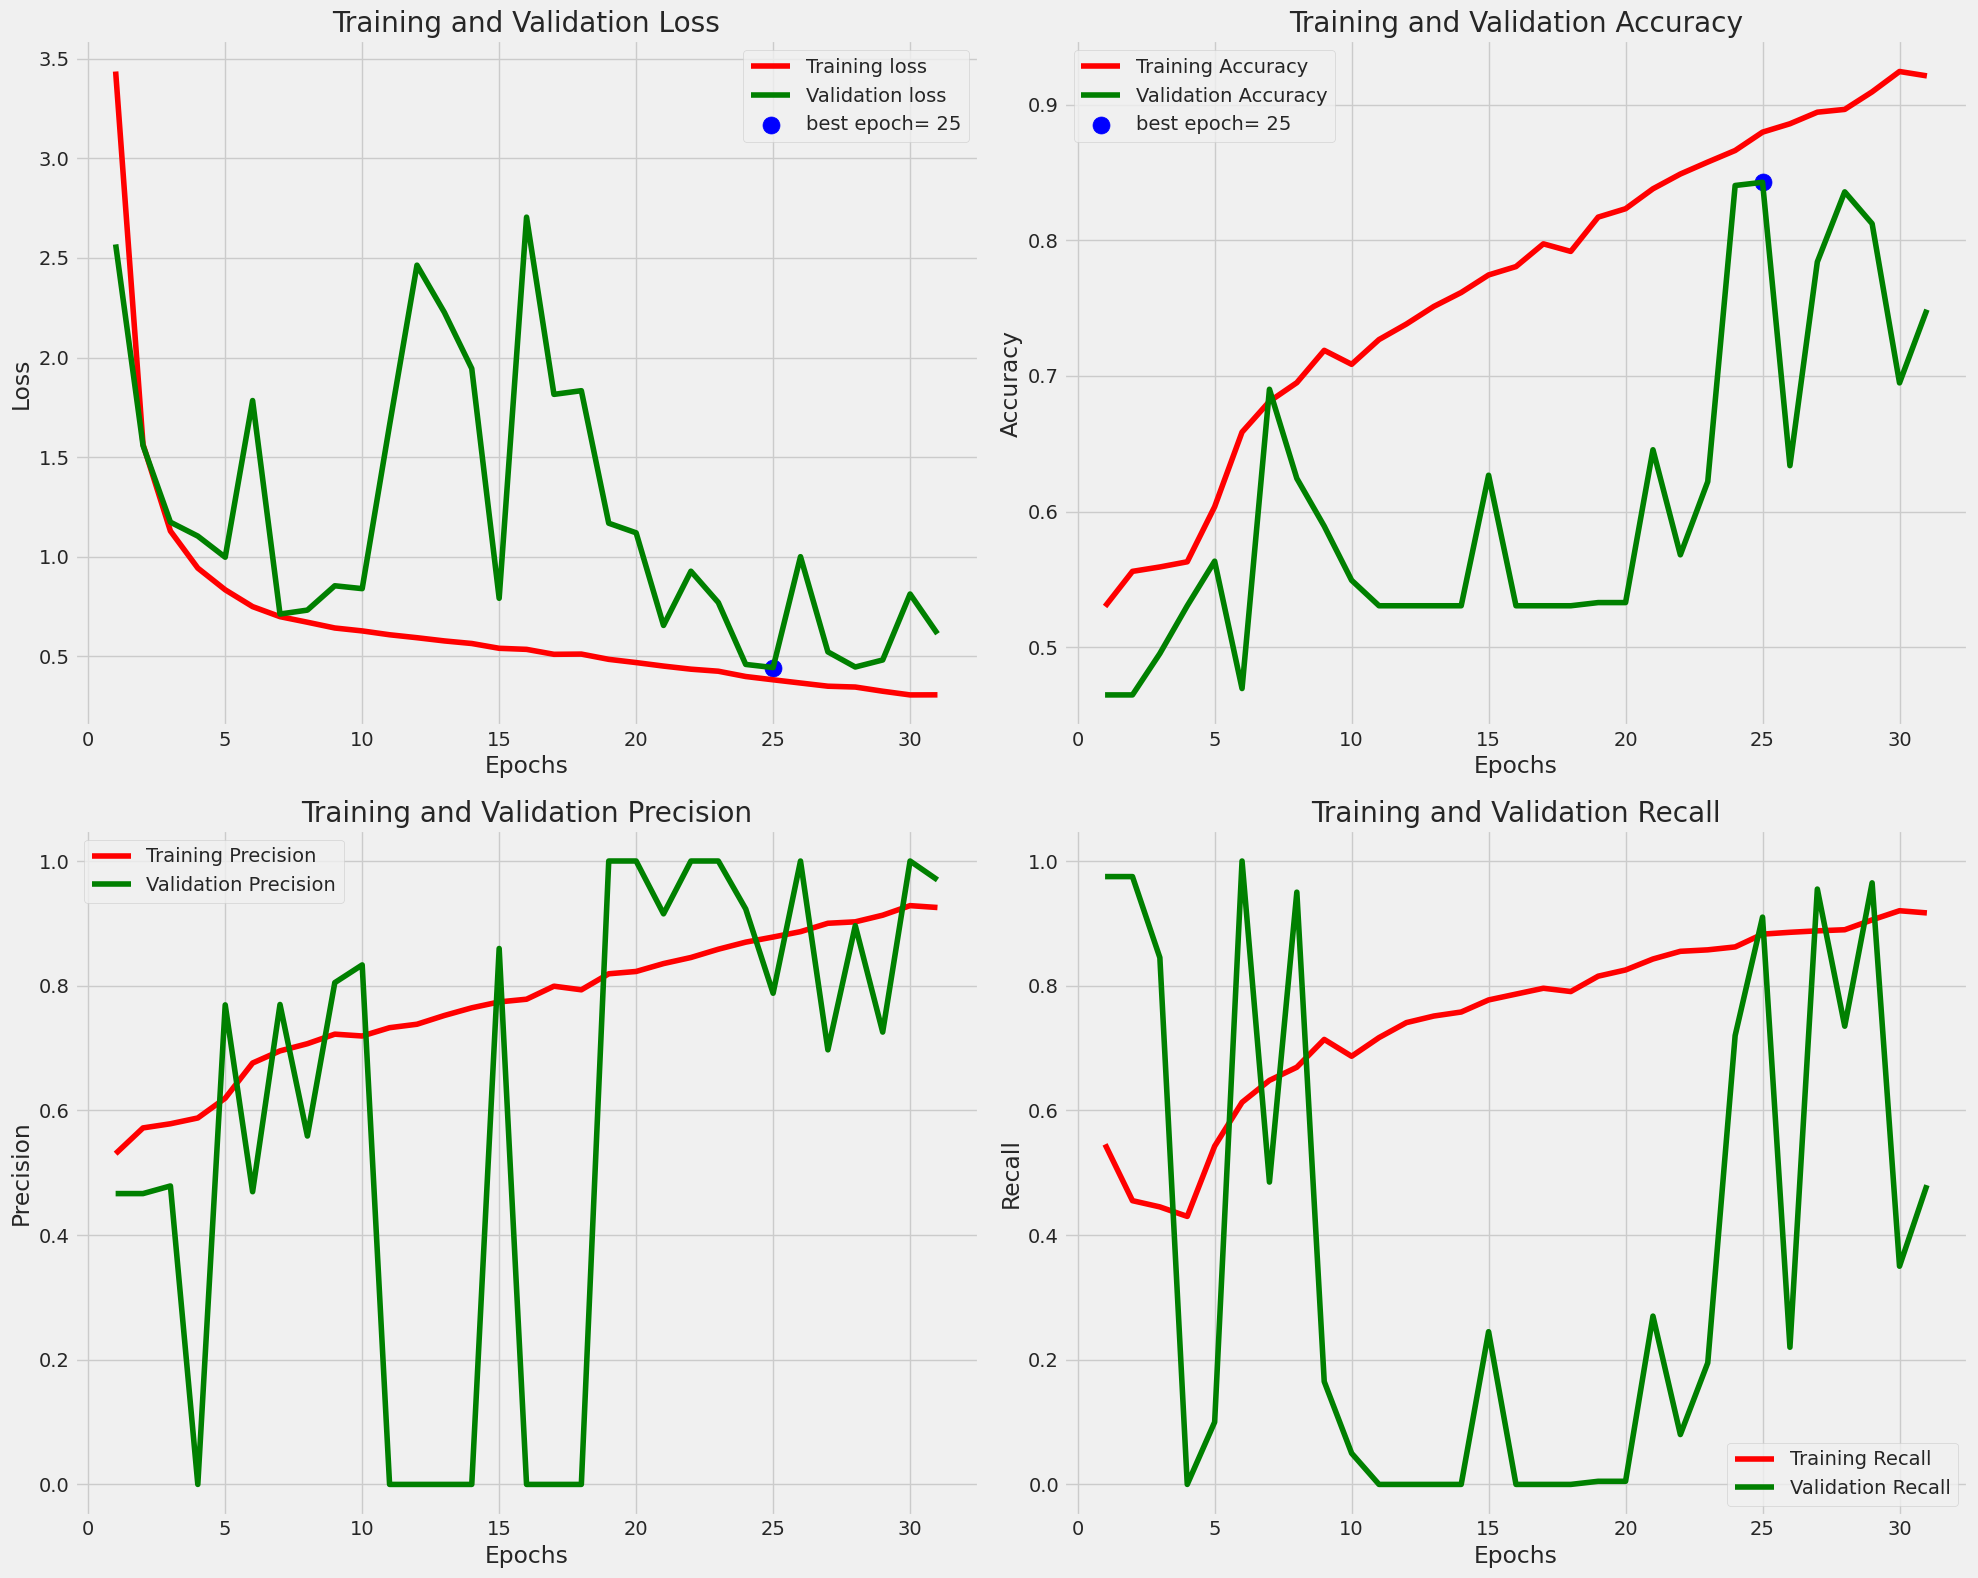

17/17 [==============================] - 2s 134ms/step - loss: 0.4710 - accuracy: 0.8235 - precision: 0.9212 - recall: 0.7103
accuracy on the test set is 82.35 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


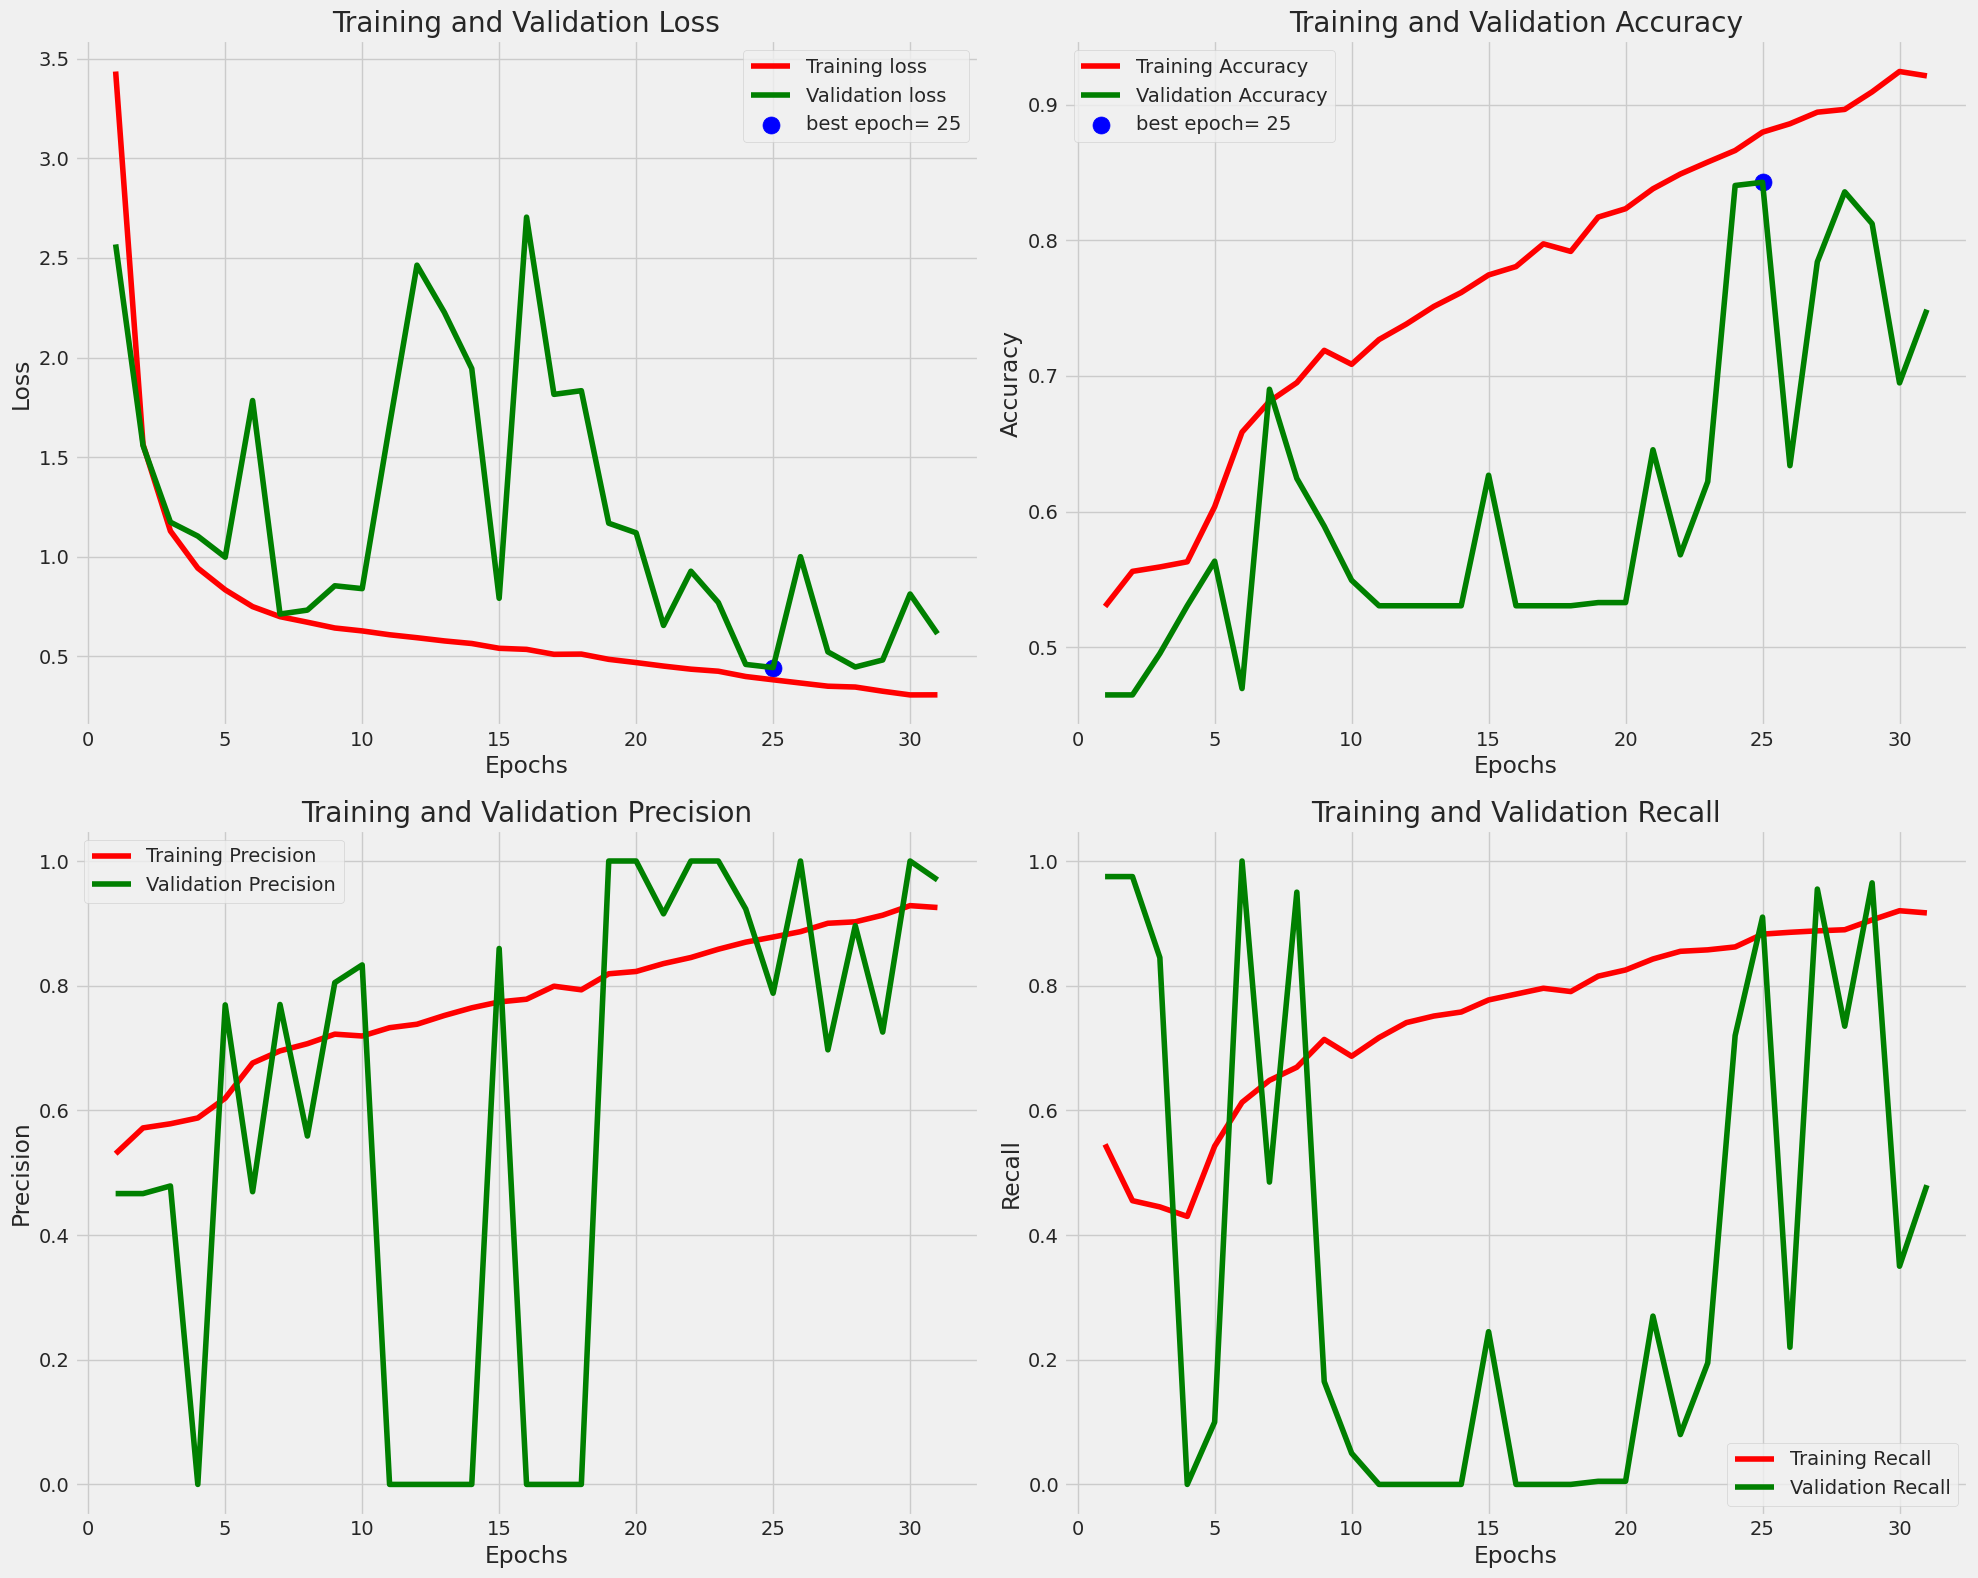

In [ ]:
tr_plot(history,0,'precision','recall')
save_dir=r'/content/drive/MyDrive/finalproject2/save1'
subject='fruits'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_gen provides test data and test_labels provides true labels
test_data, test_labels = test_gen.next()

# Predict labels for test data
y_pred_probs = model.predict(test_data)
y_pred = np.round(y_pred_probs).astype(int)

# Compute confusion matrix
cm = confusion_matrix(test_labels, y_pred)

print("Confusion Matrix:")
print(cm)

1/1 [==============================] - 0s 359ms/step
Confusion Matrix:
[[12  1]
 [ 2 10]]
1/1 [==============================] - 0s 31ms/step
Confusion Matrix:
[[12  1]
 [ 3  9]]


1/1 [==============================] - 0s 25ms/step


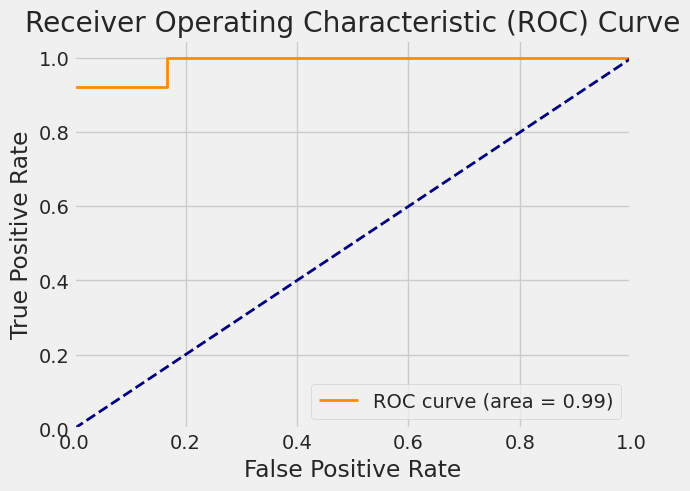

1/1 [==============================] - 0s 25ms/step


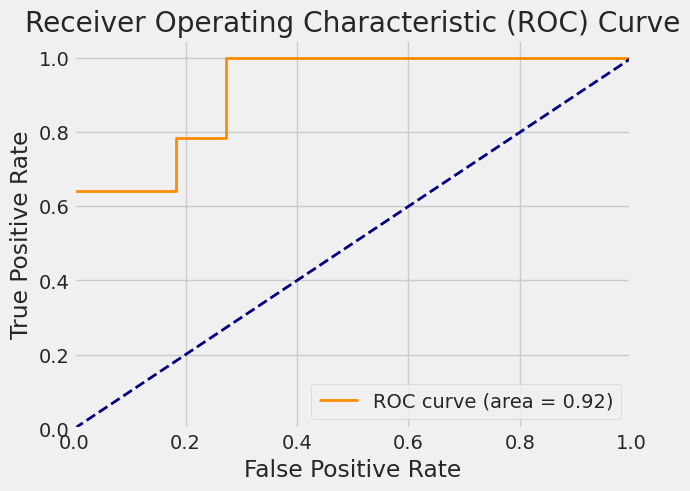

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming test_gen provides test data and test_labels provides true labels
test_data, test_labels = test_gen.next()

# Predict probabilities for test data
y_pred_probs = model.predict(test_data)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# RESNET50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
model_name1='ResNet50'
base_model1 = ResNet50(input_shape=(224, 224, 3), weights='imagenet', pooling="avg", include_top=False)
x1=base_model1.output
x1=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x1)
x1 = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x1)
x1=Dropout(rate=.45, seed=123)(x1)
output1=Dense(1 , activation='sigmoid')(x1)
model1=Model(inputs=base_model1.input, outputs=output1)
model1.compile(Adamax(lr=.001), loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])


94765736/94765736 [==============================] - 3s 0us/step


In [ ]:
logdir1 = os.path.join("logs/Adamax", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback1 = tf.keras.callbacks.TensorBoard(logdir1, histogram_freq=1)
callbacks1=[LRA(model=model1,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name1, freeze=freeze, initial_epoch=0 ),tensorboard_callback1]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history1=model1.fit(x=train_gen,  epochs=epochs, callbacks=callbacks1, verbose=0,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model ResNet50 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /50     6.657   67.706   6.37353  53.052   0.00100  0.00100  accuracy   80.07  

 2 /50     4.554   79.500   4.10604  46.948   0.00100  0.00100  accuracy   38.82  

 3 /50     3.470   84.941   3.37170  46.948   0.00100  0.00100  accuracy   38.88  

 4 /50     2.649   90.882   2.80790  50.939   0.00100  0.00100  val_loss   38.90  

 5 /50     2.080   93.912   2.37635  46.948   0.00100  0.00100  val_loss   38.79  

 6 /50     1.661   94.853   1.96048  54.930   0.00100  0.00100  val_loss   38.83  

 7 /50     1.312   96.000   1.61535  66.901   0.00100  0.00100  val_loss   39.11  

 8 /50     1.037   96.765   1.21763  79.812   0.00100  0.00100  val_loss   38.67  

 9 /50     0.841   96.588   0.96894  87.324   0.00100  0.00100  val_loss   39.16  

10 /50     0.661   97.676   0.79191  87.559   0.00100  0.00100  val_loss   38.81  

11 /50   

In [ ]:
keys1 = history.history.keys()
print(keys1)

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])
dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])


17/17 [==============================] - 4s 107ms/step - loss: 0.4773 - accuracy: 0.8988 - precision_1: 0.8869 - recall_1: 0.9159
accuracy on the test set is 89.88 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


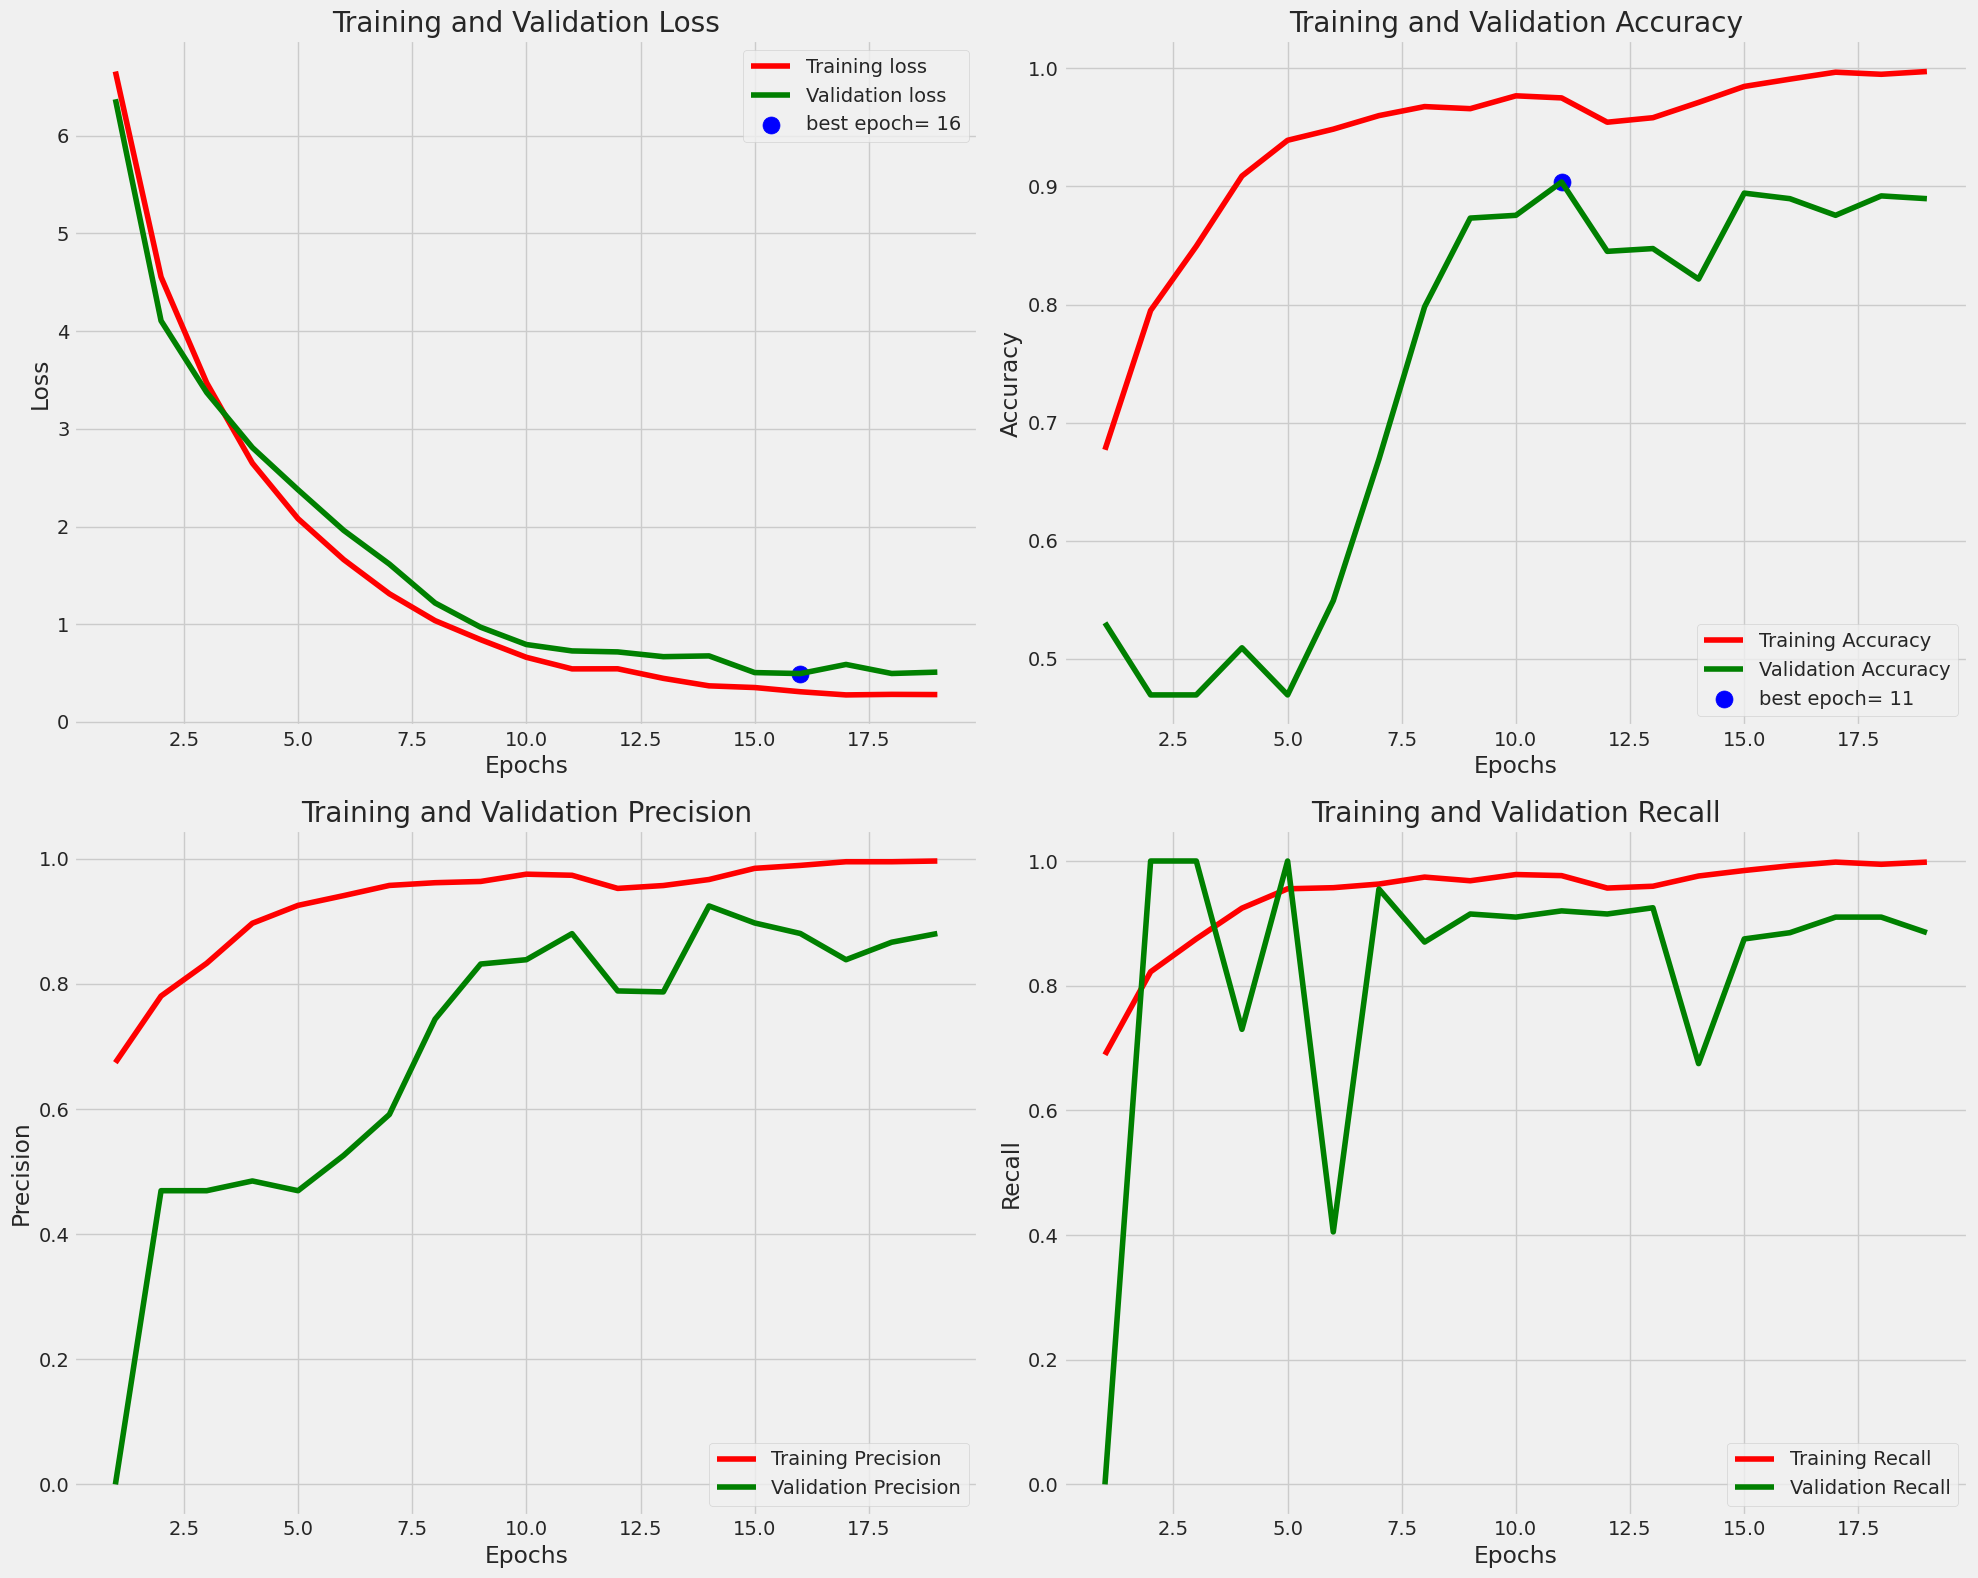

KeyError: 'precision_1'

In [ ]:
tr_plot(history1,0,'precision_1','recall_1')
save_dir=r'/content/drive/MyDrive/finalproject2/save2'
subject='fruit'
acc=model1.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name1 +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc1=os.path.join(save_dir, save_id)
model1.save(save_loc1)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_gen provides test data and test_labels provides true labels
test_data, test_labels = test_gen.next()

# Predict labels for test data
y_pred_probs = model1.predict(test_data)
y_pred = np.round(y_pred_probs).astype(int)

# Compute confusion matrix
cm = confusion_matrix(test_labels, y_pred)

print("Confusion Matrix:")
print(cm)

1/1 [==============================] - 1s 1s/step
Confusion Matrix:
[[11  1]
 [ 1 12]]


1/1 [==============================] - 0s 32ms/step


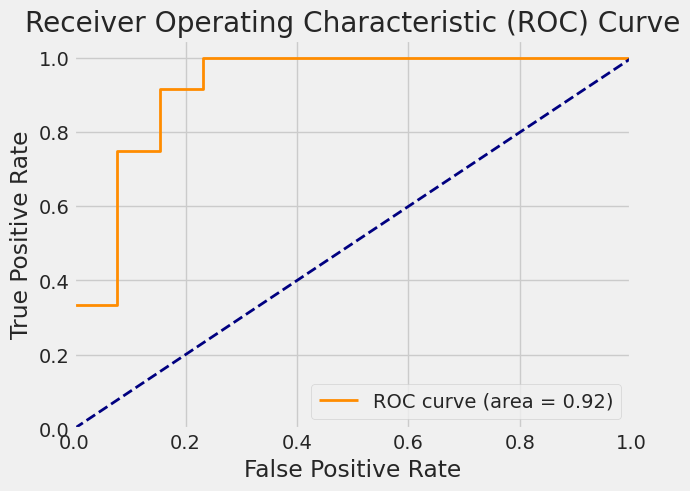

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming test_gen provides test data and test_labels provides true labels
test_data, test_labels = test_gen.next()

# Predict probabilities for test data
y_pred_probs = model1.predict(test_data)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# INCEPTIONV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
model_name2='InceptionV3'
base_model2 = InceptionV3(input_shape=(224, 224, 3), weights='imagenet', pooling="avg", include_top=False)
x2=base_model2.output
x2=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x2)
x2 = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x2)
x2=Dropout(rate=.45, seed=123)(x2)
output2=Dense(1 , activation='sigmoid')(x2)
model2=Model(inputs=base_model2.input, outputs=output2)
model2.compile(Adamax(lr=.001), loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])

87910968/87910968 [==============================] - 3s 0us/step


In [ ]:
logdir2 = os.path.join("logs2/Adamax", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback2 = tf.keras.callbacks.TensorBoard(logdir2, histogram_freq=1)
callbacks2=[LRA(model=model2,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name2, freeze=freeze, initial_epoch=0 ),tensorboard_callback2]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history2=model2.fit(x=train_gen,  epochs=epochs, callbacks=callbacks2, verbose=0,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model InceptionV3 training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /50     6.751   68.529  663.70361 62.911   0.00100  0.00100  accuracy   73.28  

 2 /50     4.592   83.265   5.73780  75.352   0.00100  0.00100  accuracy   27.46  

 3 /50     3.422   89.676   3.25417  73.005   0.00100  0.00100  accuracy   28.14  

 4 /50     2.563   94.059   2.58151  83.099   0.00100  0.00100  val_loss   27.32  

 5 /50     1.943   95.853   2.20518  88.263   0.00100  0.00100  val_loss   27.21  

 6 /50     1.484   96.735   1.72662  86.854   0.00100  0.00100  val_loss   27.34  

 7 /50     1.164   96.353   1.28567  82.864   0.00100  0.00100  val_loss   27.30  

 8 /50     0.896   96.794   1.12028  81.690   0.00100  0.00100  val_loss   27.39  

 9 /50     0.699   97.735   1.82425  83.099   0.00100  0.00050  val_loss   27.39  

10 /50     0.710   98.794   0.85398  89.671   0.00050  0.00050  val_loss   27.14  

11 /50

17/17 [==============================] - 5s 106ms/step - loss: 1.0382 - accuracy: 0.8729 - precision_2: 0.8636 - recall_2: 0.8879
accuracy on the test set is 87.29 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


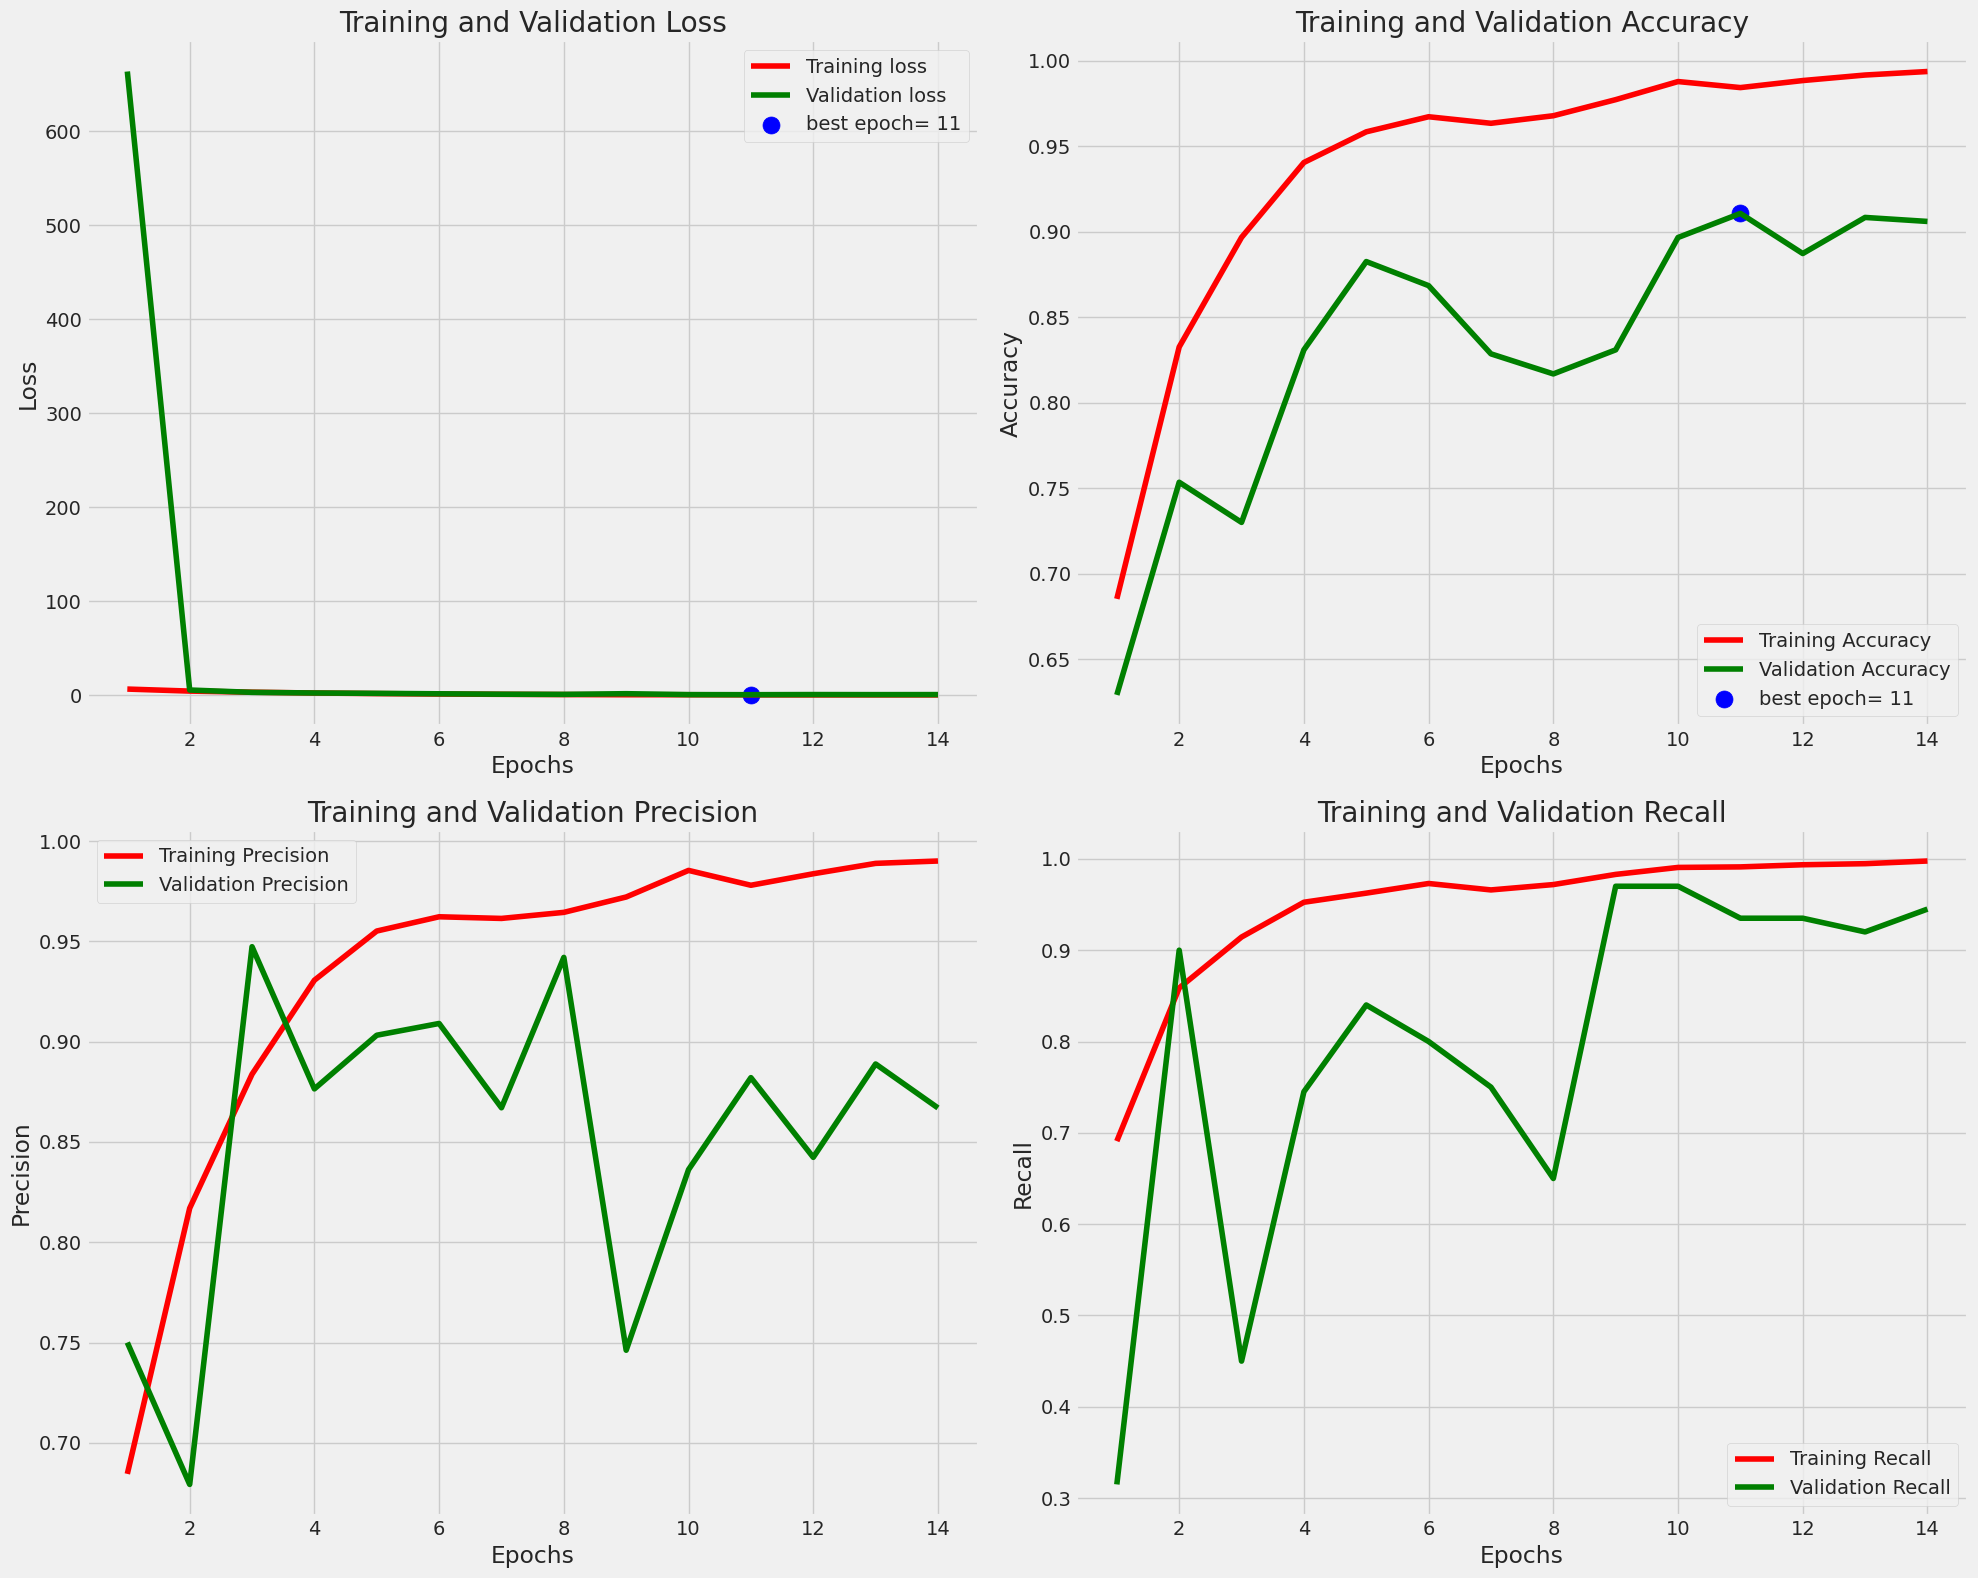

In [ ]:
tr_plot(history2,0,'precision_2','recall_2')
save_dir=r'/content/drive/MyDrive/finalproject2/save3'
subject='frui'
acc=model2.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name2 +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc2=os.path.join(save_dir, save_id)
model2.save(save_loc2)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_gen provides test data and test_labels provides true labels
test_data, test_labels = test_gen.next()

# Predict labels for test data
y_pred_probs = model2.predict(test_data)
y_pred = np.round(y_pred_probs).astype(int)

# Compute confusion matrix
cm = confusion_matrix(test_labels, y_pred)

print("Confusion Matrix:")
print(cm)

1/1 [==============================] - 1s 1s/step
Confusion Matrix:
[[11  0]
 [ 1 13]]


1/1 [==============================] - 0s 31ms/step


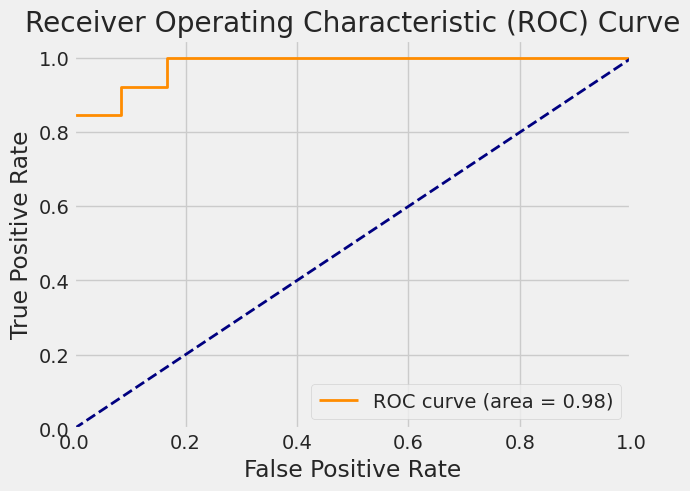

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming test_gen provides test data and test_labels provides true labels
test_data, test_labels = test_gen.next()

# Predict probabilities for test data
y_pred_probs = model2.predict(test_data)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# ENSEMBLE_MODEL

In [ ]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Average
model_1 = load_model(save_loc)
model_1 = Model(inputs=model_1.inputs,
                outputs=model_1.outputs,
                name='name_of_model_1')
model_2 = load_model(save_loc1)
model_2 = Model(inputs=model_2.inputs,
                outputs=model_2.outputs,
                name='name_of_model_2')
model_3 = load_model(save_loc2)
model_3 = Model(inputs=model_3.inputs,
                outputs=model_3.outputs,
                name='name_of_model_3')

models = [model_1, model_2,model_3]
model_input = Input(shape=(224, 224, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = Average()(model_outputs)
ensemble_model = Model(inputs=model_input, outputs=ensemble_output, name='ensemble')

# ensemble_model.compile(optimizer='adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy',Precision(),Recall()])
ensemble_model.compile(Adamax(lr=.001), loss='binary_crossentropy', metrics=['accuracy',Precision(),Recall()])

In [ ]:
model_name3 = 'Ensemble_model'
logdir3 = os.path.join("logs3/Adamax", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback3 = tf.keras.callbacks.TensorBoard(logdir3, histogram_freq=1)
callbacks3=[LRA(model=ensemble_model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,dwell=dwell, model_name=model_name3, freeze=freeze, initial_epoch=0 ),tensorboard_callback3]
LRA.tepochs=epochs  # used to determine value of last epoch for printing
history3=ensemble_model.fit(x=train_gen,  epochs=epochs, callbacks=callbacks3, verbose=0,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

 Starting training using base model Ensemble_model training all layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR   Monitor  Duration

 1 /50     0.661   91.912  15.48632  82.160   0.00100  0.00100  val_loss   177.56 

 2 /50     0.438   96.441   0.98804  84.742   0.00100  0.00100  val_loss   113.16 

 3 /50     0.384   96.824   0.62577  81.455   0.00100  0.00100  val_loss   114.34 

 4 /50     0.345   97.971   0.60307  80.986   0.00100  0.00100  val_loss   113.72 

 5 /50     0.314   98.029   0.50572  88.732   0.00100  0.00100  val_loss   113.07 

 6 /50     0.287   99.206   0.52703  87.324   0.00100  0.00050  val_loss   112.54 

 7 /50     0.275   99.500   0.38093  92.019   0.00050  0.00050  val_loss   112.42 

 8 /50     0.260   99.735   0.35381  93.897   0.00050  0.00050  val_loss   112.97 

 9 /50     0.251   99.588   0.40844  88.732   0.00050  0.00025  val_loss   112.60 

10 /50     0.244   99.882   0.37558  91.784   0.00025  0.00013  val_loss   112.33 

11 

17/17 [==============================] - 5s 269ms/step - loss: 0.3613 - accuracy: 0.9271 - precision_3: 0.9336 - recall_3: 0.9206
accuracy on the test set is 92.71 %



/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


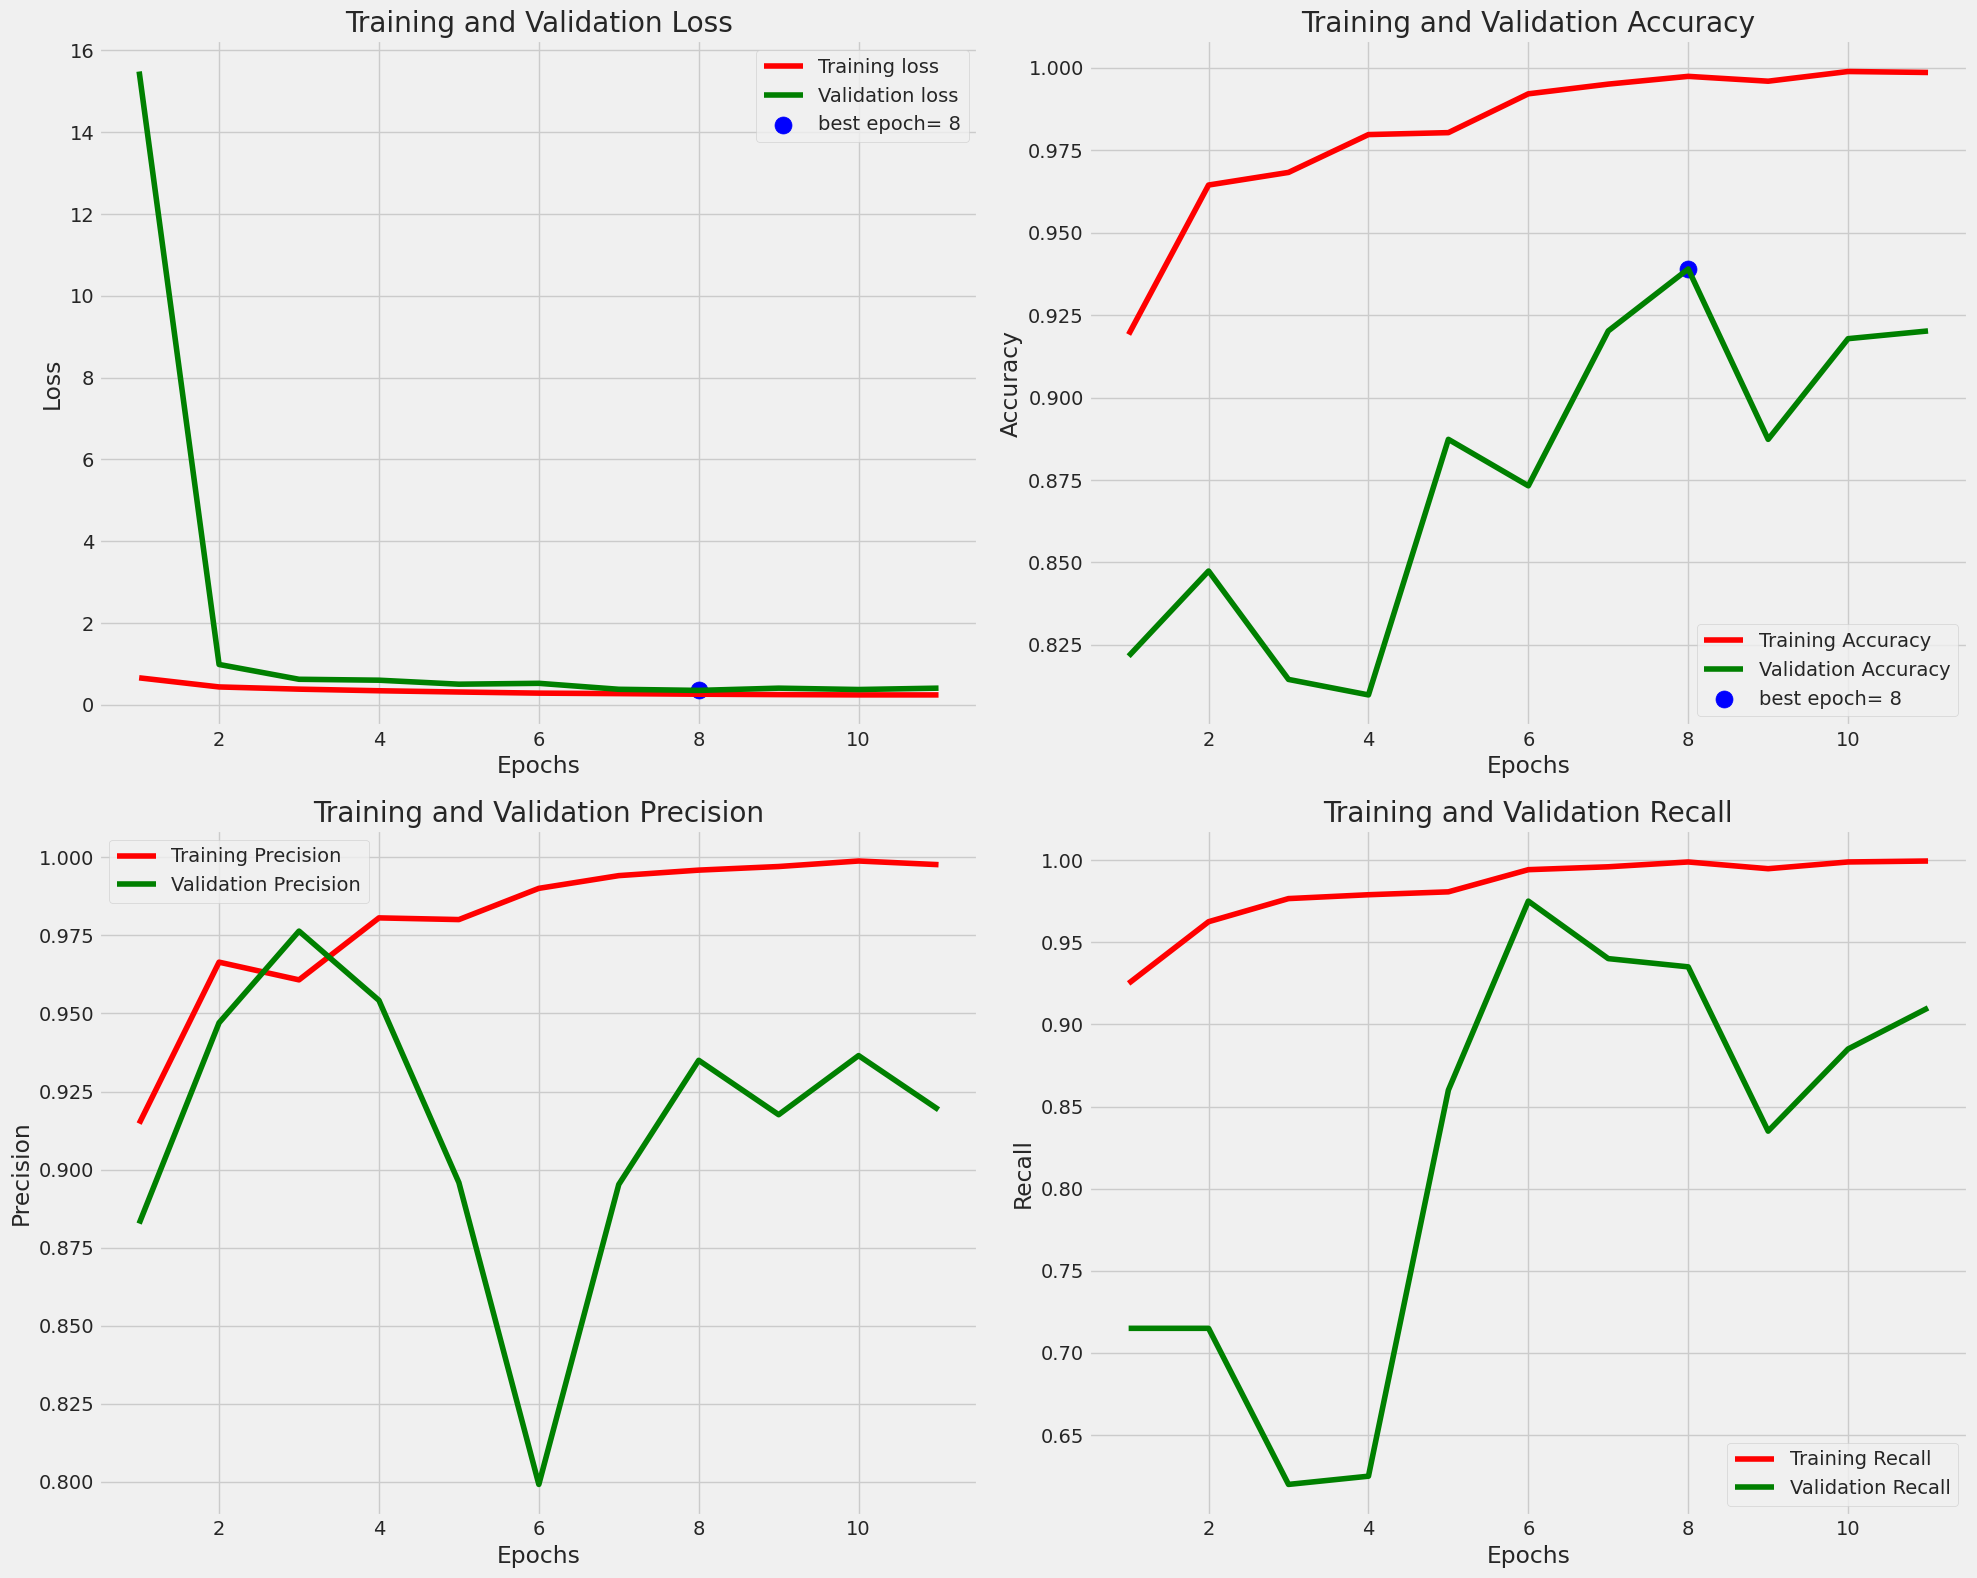

In [ ]:
tr_plot(history3,0,'precision_3','recall_3')
save_dir=r'/content/drive/MyDrive/finalproject2/save4'
subject='fru'
acc=ensemble_model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))
save_id=str (model_name3 +  '-' + subject +'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc3=os.path.join(save_dir, save_id)
ensemble_model.save(save_loc3)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_gen provides test data and test_labels provides true labels
test_data, test_labels = test_gen.next()

# Predict labels for test data
y_pred_probs = ensemble_model.predict(test_data)
y_pred = np.round(y_pred_probs).astype(int)

# Compute confusion matrix
cm = confusion_matrix(test_labels, y_pred)

print("Confusion Matrix:")
print(cm)

1/1 [==============================] - 3s 3s/step
Confusion Matrix:
[[11  1]
 [ 1 12]]


1/1 [==============================] - 0s 45ms/step


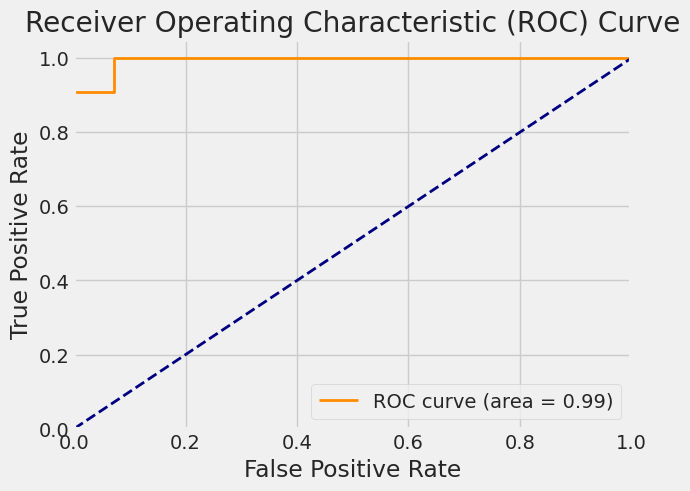

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming test_gen provides test data and test_labels provides true labels
test_data, test_labels = test_gen.next()

# Predict probabilities for test data
y_pred_probs = ensemble_model.predict(test_data)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_labels, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()